## Benchmark: ARIMA, RNN & LSTM

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
%matplotlib inline
import os 
os.chdir('../.')
import sys
sys.path.append('Transformer')

Functions

In [11]:
def actual_pred_plot(preds, y_test):
    '''
    Plot the actual vs. prediction
    '''
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['prediction'] = preds[:,0]
    actual_pred['Adj. Close'] = y_test[:,0]  #.loc['2019':,'Adj Close'][0:len(preds)]

    from tensorflow.keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))
    return (m.result().numpy(), actual_pred.plot() )

### Data

In [12]:
from utils import get_fx_and_metric_data
df = get_fx_and_metric_data(dtype=np.float32)

/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Create training and test data for RNN/LSTM

In [14]:
def ts_train_test_normalize(df,time_steps,for_periods, target_column=3):
    '''
    input: 
      data: dataframe with dates and price data
    output:
      X_train, y_train: data from 2020/11/2-2020/12/31
      X_test:  data from 2021 -
      sc:      insantiated MinMaxScaler object fit to the training data
    '''    # create training and test set
    times = sorted(df.index.values)
    last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
    last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

    ts_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
    index_train = df[df.index < last_20pct].index
    ts_test = df[(df.index >= last_20pct) & (df.index < last_10pct)]
    index_test = df[(df.index >= last_20pct) & (df.index < last_10pct)].index

    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    '''Normalize price columns'''
#     df = (df - df.mean()) / (df.max() - df.min())
#     df.columns[np.isnan(df).any(axis=0)]
    
    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train.to_numpy()[i-time_steps:i])
        y_train.append(ts_train.to_numpy()[i:i+for_periods,target_column])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
#     X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    # Preparing X_test
    X_test = []
    y_test = []
    for i in range(time_steps,ts_test_len-for_periods):
        X_test.append(ts_test.to_numpy()[i-time_steps:i])
        y_test.append(ts_test.to_numpy()[i:i+for_periods,target_column])
    
    X_test, y_test = np.array(X_test), np.array(y_test)
#     X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

    return X_train, y_train , X_test, y_test, index_train, index_test

In [15]:
target_column = list(df.columns).index('EURUSD BGNE Curncy Bid Close')

X_train, y_train, X_test, y_test, index_train, index_test = ts_train_test_normalize(df, 1, 1, target_column)

## ARIMA

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import yule_walker

#from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pmdarima as pmd

In [17]:
p = adfuller(X_train[:, 0, target_column])[1]
print("p-value:", p)
print(f"Differencing is {'' if p > 0.05 else 'not '}necessary")

p-value: 0.0
Differencing is not necessary


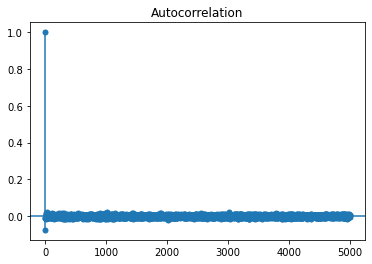

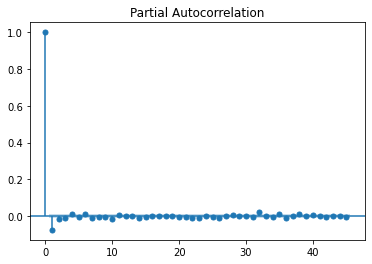

In [18]:
plot_acf(X_train[:, 0, target_column], lags=5000)  # ACF
# plt.ylim(0, 0.2)
plt.show()
plot_pacf(X_train[:, 0, target_column])
# plt.ylim(-0.1, 0.1)
plt.show()

In [19]:
g = grangercausalitytests(X_train[:, 0, target_column:(target_column+2)], maxlag =10, verbose = 0)
g[1]

({'ssr_ftest': (28.289285079802283, 1.0518576602131529e-07, 31444.0, 1),
  'ssr_chi2test': (28.29198409567938, 1.0432711111408042e-07, 1),
  'lrtest': (28.27926497149747, 1.0501487576015511e-07, 1),
  'params_ftest': (28.28928507980842, 1.0518576602076672e-07, 31444.0, 1.0)},
  array([[0., 1., 0.]])])

In [20]:
print(f"ndiffs: {pmd.arima.ndiffs(X_train[:, 0, target_column])}")
print(f"nsdiffs: {pmd.arima.nsdiffs(X_train[:, 0, target_column], m=2)}")

ndiffs: 0
nsdiffs: 0


In [21]:
# see https://www.pluralsight.com/guides/advanced-time-series-modeling-(arima)-models-in-python
arima = pmd.auto_arima(
    X_train[:, 0, target_column],
    d=pmd.arima.ndiffs(X_train[:, 0, target_column]),
    start_p=1,
    max_p=20,
    start_q=0,
    max_q=20,
    start_P=0,
    start_Q=0,
    max_P=3,
    max_Q=3,
    test='adf',
    trace=True
)
arima

Performing stepwise search to minimize aic
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-423456.078, Time=5.38 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-423283.240, Time=3.97 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-423460.155, Time=14.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-423284.521, Time=0.86 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-423460.796, Time=11.42 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-423454.766, Time=18.36 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-423453.669, Time=9.23 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-423460.638, Time=18.84 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-423460.017, Time=6.35 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-423457.327, Time=10.70 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-423461.960, Time=1.66 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-423461.313, Time=1.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-423457.245, Time=1.21 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-423456.164, 

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [23]:
mod = sm.tsa.arima.ARIMA(
    X_train[:,0, target_column],
#     exog=X_train[:,0, [i for i in range(min(10, X_train.shape[2])) if i !=3]],
    order=arima.get_params()['order'],
    seasonal_order=arima.get_params()['seasonal_order']
)
model_train = mod.fit()
print(model_train.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                31448
Model:                 ARIMA(1, 0, 1)   Log Likelihood              211734.413
Date:                Mon, 18 Oct 2021   AIC                        -423460.826
Time:                        11:50:53   BIC                        -423427.402
Sample:                             0   HQIC                       -423450.125
                              - 31448                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.373e-06   1.52e-06      0.902      0.367   -1.61e-06    4.36e-06
ar.L1          0.1237      0.001    135.268      0.000       0.122       0.125
ma.L1         -0.1993      0.001   -216.960      0.0

In [31]:
from sklearn.metrics import r2_score
r2_score(X_train[:,0, target_column], model_train.predict())

0.005757719515481874

In [32]:
y_train_pred = model_train.predict()

In [33]:
m_min = np.min([y_train.min(), y_train_pred[y_train_pred != 0].min()])
m_max = np.max([y_train.max(), y_train_pred.max()])

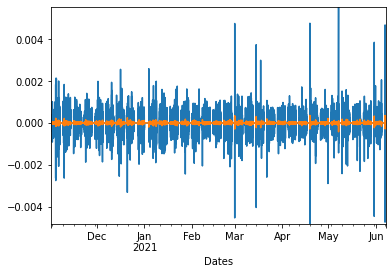

In [34]:
pd.Series(
    data=y_train[:, 0],
    index=index_train[-y_train_pred.shape[0]:],
).plot()
pd.Series(
    data=y_train_pred,
    index=index_train[-y_train_pred.shape[0]:],
).plot()
plt.ylim(m_min, m_max)
plt.show()

In [35]:
y_pred_error = pd.Series(
    data=y_train_pred.flatten() - y_train.flatten(),
    index=index_train[-y_train_pred.shape[0]:],
).iloc[1:]

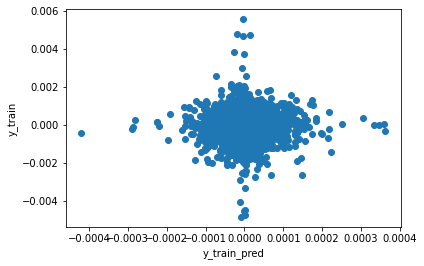

Text(0.5, 1.0, 'QQ-lot for y_train_pred - y_train')

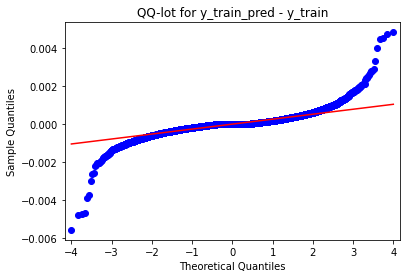

In [36]:
# y_pred_error.plot()
# plt.show()
plt.scatter(y_train_pred[1:], y_train[1:])
plt.xlabel('y_train_pred')
plt.ylabel('y_train')
plt.show()
import statsmodels.api as smi
smi.qqplot(y_pred_error[1:], line = "r")
plt.title('QQ-lot for y_train_pred - y_train')
# pylab.show()

In [37]:
y = y_train
y_pred = y_train_pred
print(f'mse: {mean_squared_error(y_pred, y)}')
print(f'mae: {mean_absolute_error(y_pred, y)}')
mape = np.abs((y_pred.flatten() - y.flatten()) / y.flatten())
print(f'mape: {np.ma.masked_invalid(mape).mean()}')
print(f'mde: {1 - np.mean(np.diff(y.flatten()) * (y_pred.flatten() - y.flatten())[1:] >= 0)}')


mse: 8.394200129582611e-08
mae: 0.000162525828082083
mape: 1.0378194481357972
mde: 0.5473972080007632


<ipython-input-37-e4f981266244>:5: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.abs((y_pred.flatten() - y.flatten()) / y.flatten())


In [38]:
mod2 = sm.tsa.arima.ARIMA(
    X_test[:, 0, target_column],
#     exog=X_test[:,0, [i for i in range(min(10, X_test.shape[2])) if i !=3]],
    order=arima.get_params()['order'],
    seasonal_order=arima.get_params()['seasonal_order']
)
with mod2.fix_params(dict(zip(model_train.param_names, model_train.params))):
    model_test = mod2.fit()
print(model_test.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3929
Model:                 ARIMA(1, 0, 1)   Log Likelihood               26812.326
Date:                Mon, 18 Oct 2021   AIC                         -53624.651
Time:                        11:54:14   BIC                         -53624.651
Sample:                             0   HQIC                        -53624.651
                               - 3929                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const (fixed)   1.373e-06        nan        nan        nan         nan         nan
ar.L1 (fixed)      0.1237        nan        nan        nan         nan         nan
ma.L1 (fixed)     -0.1993        nan

Get model for test data.

(9.308414e-08, <AxesSubplot:>)

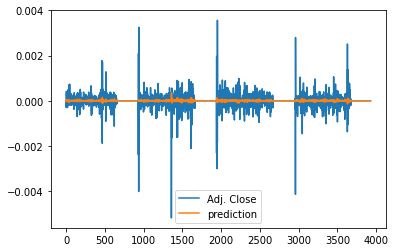

In [39]:
actual_pred_plot(model_test.predict().reshape([-1,1]), X_test[:, 0, 3:4])

<AxesSubplot:xlabel='Dates'>

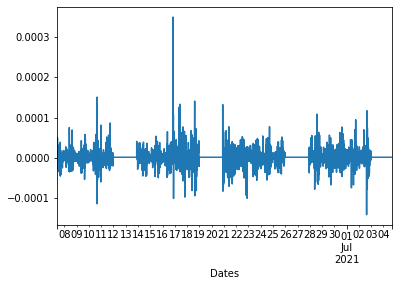

In [40]:
y_test_pred = pd.Series(
    data=model_test.predict(),
    index=index_test[-model_test.predict().shape[0]:],
)
y_test_pred.plot()

In [46]:
y = y_test
y_pred = y_test_pred
print(y.shape)
print(y_pred.shape)
print(f'mse: {mean_squared_error(y_pred, y)}')
print(f'mae: {mean_absolute_error(y_pred, y)}')
mape = np.abs((y_pred.to_numpy().flatten() - y.flatten()) / y.flatten())
print(f'mape: {np.ma.masked_invalid(mape).mean()}')
print(f'mde: {1 - np.mean(np.diff(y.flatten()) * (y_pred - y.flatten())[1:] >= 0)}')

(3929, 1)
(3929,)
mse: 6.806893763332759e-08
mae: 0.0001455699978166172
mape: 1.0228435000950855
mde: 0.5483706720977597


<ipython-input-46-ea75cd72aad4>:7: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.abs((y_pred.to_numpy().flatten() - y.flatten()) / y.flatten())
